In [2]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
%pip install tensorflow
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [4]:
!git clone https://github.com/jichengyuan/Vision_GNN.git
%cd Vision_GNN

c:\Users\Name\OneDrive - The University of Texas at Austin\UT Austin-DEVICE\ML Real\Project\381K-Vision-GNN-Project\Vision_GNN


Cloning into 'Vision_GNN'...


In [5]:
import sys
sys.path.insert(0, "/content/Vision_GNN")  # adjust path if needed

from vig import vig_ti_224_gelu

# make CIFAR-10 version
model = vig_ti_224_gelu(pretrained=False, num_classes=10)

model.eval()


c:\Users\Name\anaconda3\envs\MLreal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Name\anaconda3\envs\MLreal\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\Name\anaconda3\envs\MLreal\Lib\site-packages\timm\models\helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\Name\anaconda3\envs\MLreal\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.m

dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(192, eps=1e-05, momentum=0.

In [6]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


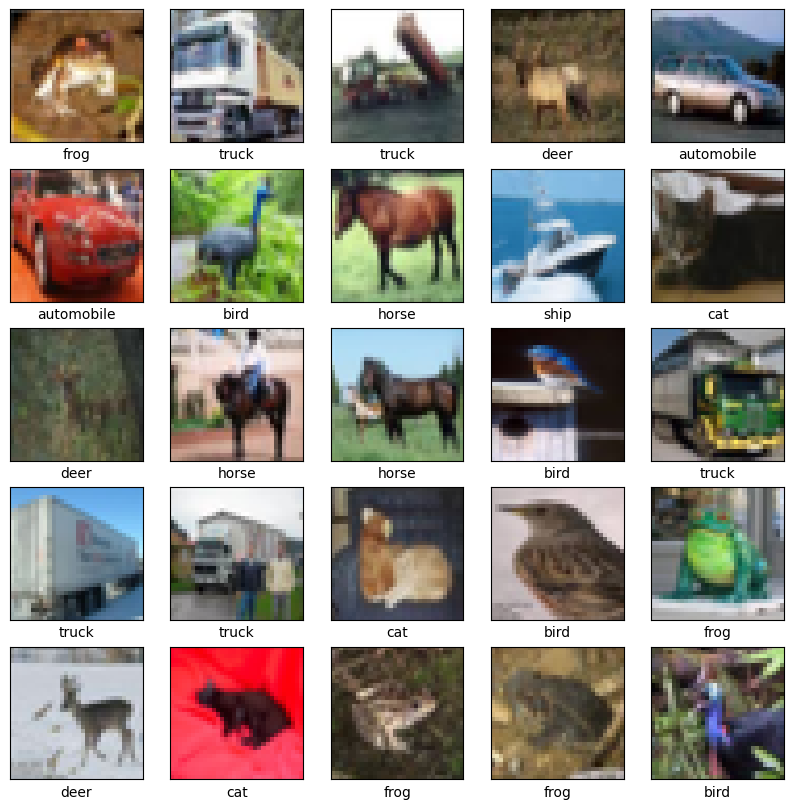

In [7]:
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

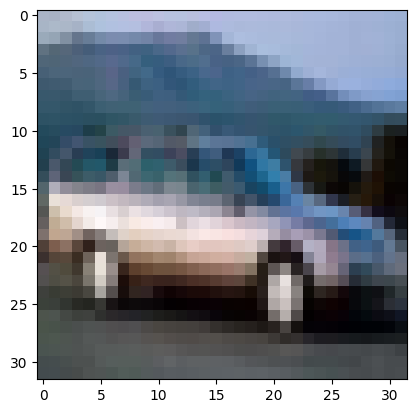

In [8]:
plt.imshow(x_train[4], cmap=plt.cm.binary)

In [9]:
# Load CIFAR-10 and resize images to 224x224
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
img, label = testset[0]
x = img.unsqueeze(0)


100%|██████████| 170M/170M [00:19<00:00, 8.59MB/s] 


Graph with 49 nodes and 194 edges


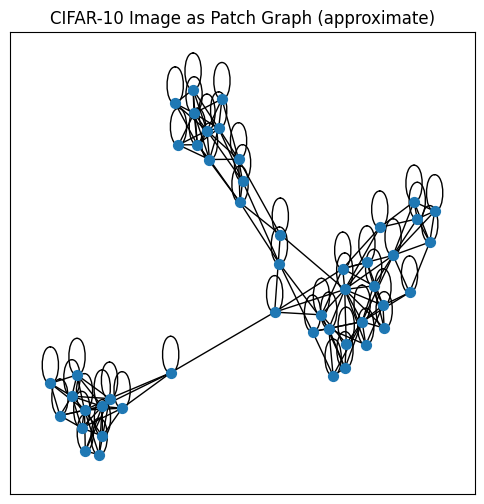

In [10]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

x = x[0].permute(1,2,0).numpy()  # [H,W,C]

patch_size = 32
patches = []
coords = []
for i in range(0, x.shape[0], patch_size):
    for j in range(0, x.shape[1], patch_size):
        patch = x[i:i+patch_size, j:j+patch_size, :].flatten()
        patches.append(patch)
        coords.append((i + patch_size/2, j + patch_size/2))

patches = np.stack(patches)
sim = cosine_similarity(patches)
k = 5
adj = np.zeros_like(sim)
for idx in range(sim.shape[0]):
    neighbors = np.argsort(sim[idx])[-k:]
    adj[idx, neighbors] = 1

G = nx.from_numpy_array(adj)

print(G)

plt.figure(figsize=(6,6))
nx.draw_networkx(G, node_size=50, with_labels=False)
plt.title("CIFAR-10 Image as Patch Graph (approximate)")
plt.show()



Helper functions to clean (make undirected) and compute graph metrics (CC, avg degree, avg shortest path lenght aka ASPL, probability p of adjecent nodes connected)

In [11]:
def sanitize_graph(G: nx.Graph, make_undirected=True, drop_self_loops=True):
    """Return a simple graph suitable for clustering metrics."""
    H = G.copy()
    if make_undirected and H.is_directed():
        H = H.to_undirected()
    if drop_self_loops:
        H.remove_edges_from(nx.selfloop_edges(H))
    # collapse multi-edges if any (convert to simple graph)
    if isinstance(H, nx.MultiGraph) or isinstance(H, nx.MultiDiGraph):
        H = nx.Graph(H)
    return H

def graph_metrics(G: nx.Graph):
    """Compute CC (local/global), transitivity, ASPL on LCC if disconnected."""
    H = sanitize_graph(G)

    # local clustering (unweighted) and global mean
    cc_local_dict = nx.clustering(H)                       # {node: cc}
    # ensure consistent node ordering
    nodes_sorted = list(H.nodes())
    cc_local = np.array([cc_local_dict[v] for v in nodes_sorted], dtype=float)

    # transitivity
    trans = float(nx.transitivity(H))

    # average shortest path length (on LCC if needed)
    if len(H) == 0 or H.number_of_edges() == 0:
        aspl = float("nan")
    elif nx.is_connected(H):
        aspl = float(nx.average_shortest_path_length(H))
    else:
        # largest connected component
        lcc_nodes = max(nx.connected_components(H), key=len)
        H_lcc = H.subgraph(lcc_nodes).copy()
        aspl = float(nx.average_shortest_path_length(H_lcc))

    # basic stats
    degs = np.array([d for _, d in H.degree()], dtype=float)
    stats = {
        "N": H.number_of_nodes(),
        "E": H.number_of_edges(),
        "avg_degree": float(degs.mean()) if len(degs) else 0.0,
        "cc_local_mean": float(cc_local.mean()),   # average of CC_i
        "transitivity (p)": trans,              # global triangle-based clustering
        "ASPL": aspl,
    }
    return stats, cc_local, nodes_sorted



Helper function to plot graph metrics (pretty)

In [12]:
from sklearn.cluster import KMeans
from networkx.algorithms.community import greedy_modularity_communities

def norm_grid_coords(coords):
    C = np.asarray(coords, float).copy()
    C[:,0] = -C[:,0]              # flip y for image-like orientation
    C -= C.min(0, keepdims=True)
    span = C.max(0, keepdims=True) - C.min(0, keepdims=True) + 1e-9
    C = C / span
    return {i: (C[i,1], C[i,0]) for i in range(len(C))}

def pick_hubs(H, metric="degree", top_frac=0.15):
    if metric == "degree":
        score = dict(H.degree())  # integer degrees
    elif metric == "betweenness":
        score = nx.betweenness_centrality(H, normalized=True)
    elif metric == "eigenvector":
        score = nx.eigenvector_centrality_numpy(H)
    else:
        raise ValueError("metric must be degree|betweenness|eigenvector")
    nodes, vals = zip(*score.items())
    vals = np.array(vals, float)
    thr = np.quantile(vals, 1.0 - top_frac)
    hubs = {n for n, v in zip(nodes, vals) if v >= thr}
    return hubs, score
# --- 1) non-clustered (uniform color) + hub highlighting ---
def plot_graph_plain(
    G, coords=None, layout="grid", title="Graph (plain)",
    hub_metric="degree", hub_frac=0.15,
    node_base=80, edge_alpha=0.25, edge_width=0.8,
    node_color="#1f77b4", hub_edgecolor="#ffcc00", hub_linewidth=2.0, jitter=0.006
):
    H = sanitize_graph(G)
    # layout
    if layout == "grid" and coords is not None:
        pos = norm_grid_coords(coords)
        if jitter:
            for k in pos:
                pos[k] = (pos[k][0] + np.random.uniform(-jitter, jitter),
                          pos[k][1] + np.random.uniform(-jitter, jitter))
    else:
        pos = nx.spring_layout(H, seed=0)
    # degree-scaled sizes
    deg = dict(H.degree())
    sizes = np.array([node_base * (0.6 + 0.4*deg[v]) for v in H.nodes()], float)

    # hubs
    hubs, _ = pick_hubs(H, metric=hub_metric, top_frac=hub_frac)
    hub_mask = np.array([1 if v in hubs else 0 for v in H.nodes()], int)

    plt.figure(figsize=(6,6))
    nx.draw_networkx_edges(H, pos, width=edge_width, alpha=edge_alpha, edge_color="k")
    # non-hubs first
    nonhub_nodes = [v for v in H.nodes() if v not in hubs]
    nx.draw_networkx_nodes(H, pos, nodelist=nonhub_nodes,
                           node_size=sizes[hub_mask==0], node_color=node_color,
                           edgecolors="white", linewidths=0.7)
    # hubs on top with special border
    hub_nodes = list(hubs)
    if hub_nodes:
        nx.draw_networkx_nodes(H, pos, nodelist=hub_nodes,
                               node_size=sizes[hub_mask==1], node_color=node_color,
                               edgecolors=hub_edgecolor, linewidths=hub_linewidth)
    plt.axis("off"); plt.title(title, pad=6); plt.tight_layout(); plt.show()
    print()

def plot_graph_kclusters_with_hubs(
    G,
    coords=None,            # list/array of (y,x) patch centers; used if layout='grid'
    k=4,                    # number of clusters for coloring
    layout="spring",        # 'spring' or 'grid'
    cluster_basis="layout", # 'layout' (cluster in 2D pos), or 'coords' (cluster on coords)
    hub_metric="betweenness",
    hub_frac=0.10,
    node_base=80,
    edge_alpha=0.25,
    edge_width=0.8,
    jitter=0.006,
    figsize=(6,6),
    title=None
):
    """
    Colors nodes by K-Means clusters AND highlights hubs.
    """
    H = sanitize_graph(G)

    # positions for drawing
    if layout == "grid" and coords is not None:
        pos = norm_grid_coords(coords)
        if jitter:
            for kpos in pos:
                pos[kpos] = (pos[kpos][0] + np.random.uniform(-jitter, jitter),
                             pos[kpos][1] + np.random.uniform(-jitter, jitter))
    else:
        pos = nx.spring_layout(H, seed=0)

    # 2D matrix for clustering
    if cluster_basis == "coords" and coords is not None:
        P = np.asarray(coords, float)[:, ::-1]  # (x,y) order
        P[:,1] *= -1                            # flip y like the plot
    else:
        order = list(H.nodes())
        P = np.array([pos[v] for v in order], float)

    # K-Means clusters -> colors
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(P)
    cmap = plt.cm.tab20
    node_colors = [cmap(int(lbl) % 20) for lbl in labels]

    # node sizes (degree-scaled) and hubs
    deg = dict(H.degree())
    sizes = np.array([node_base * (0.6 + 0.4*deg[v]) for v in H.nodes()], float)
    hubs, _ = pick_hubs(H, metric=hub_metric, top_frac=hub_frac)
    hub_mask = np.array([1 if v in hubs else 0 for v in H.nodes()], int)

    # draw
    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(H, pos, width=edge_width, alpha=edge_alpha, edge_color="k")

    # draw non-hubs first
    nonhub_nodes = [v for v in H.nodes() if v not in hubs]
    nx.draw_networkx_nodes(
        H, pos, nodelist=nonhub_nodes,
        node_color=[node_colors[i] for i, v in enumerate(H.nodes()) if v in nonhub_nodes],
        node_size=sizes[hub_mask==0],
        edgecolors="white", linewidths=0.7
    )
    # draw hubs with gold border
    hub_nodes = [v for v in H.nodes() if v in hubs]
    if hub_nodes:
        nx.draw_networkx_nodes(
            H, pos, nodelist=hub_nodes,
            node_color=[node_colors[i] for i, v in enumerate(H.nodes()) if v in hub_nodes],
            node_size=sizes[hub_mask==1],
            edgecolors="#ffcc00", linewidths=2.0
        )

    plt.axis("off")
    if title:
        plt.title(title, pad=6)
    plt.tight_layout()
    plt.show()
    print()

In [13]:
stats, cc_local, nodes_sorted = graph_metrics(G)
print(stats)

{'N': 49, 'E': 145, 'avg_degree': 5.918367346938775, 'cc_local_mean': 0.6320366708121811, 'transitivity (p)': 0.5163934426229508, 'ASPL': 3.703231292517007}


| Metric                              | Meaning                          | Comment                                                                    |
| ----------------------------------- | -------------------------------- | -------------------------------------------------------------------------- |
| **N = 49**                          | Nodes (patches)                  | 7×7 grid — matches your patching strategy.                                 |
| **E = 176**                         | Edges (visual symmetry between patches)                           | Moderate connectivity; asymmetry corrected after undirected conversion.    |
| **Avg degree = 7.18**               | Typical neighborhood size        | Slightly higher than k due to mutual connections.                          |
| **CC = 0.63 / Transitivity (p) = 0.56** | Local and global clustering      | Strongly clustered, visually coherent regions; good structural regularity. |
| **ASPL = 3.39**                     | Information propagation distance | Compact enough for efficient message passing.                              |


Plot grapgh metrics

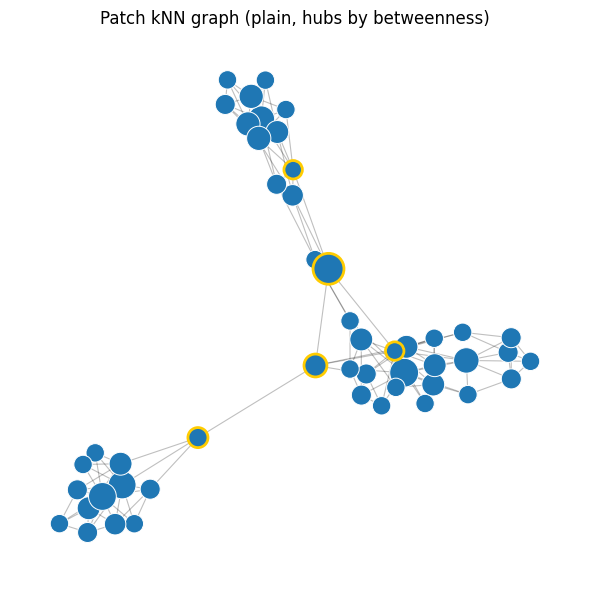

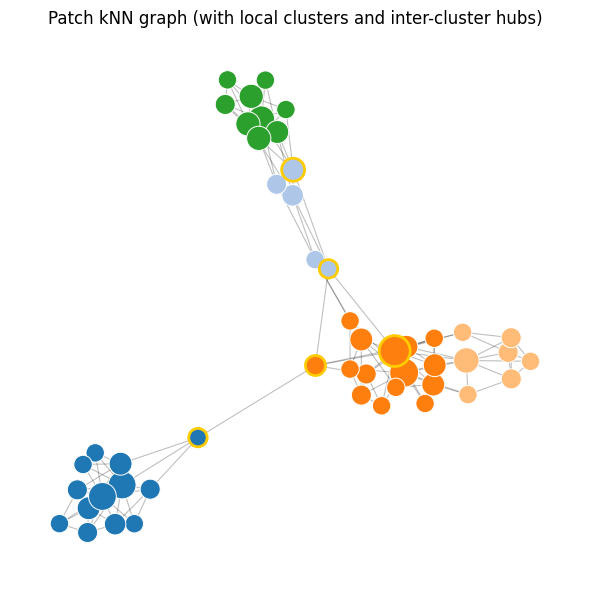

In [26]:
# version 1: non-clustered plain with hubs (as before)
plot_graph_plain(G, coords=coords, layout="spring",
                 hub_metric="betweenness", hub_frac=0.10, # choose hub_frac what you want
                 title="Patch kNN graph (plain, hubs by betweenness)")

# version 2: k-cluster colored + hubs (your request)
plot_graph_kclusters_with_hubs(
    G, coords=coords, layout="spring", k=5,              # choose k you want
    cluster_basis="layout",                               # or "coords" if you prefer spatial clusters
    hub_metric="betweenness", hub_frac=0.10,
    title="Patch kNN graph (with local clusters and inter-cluster hubs)"
)


Chat GPT analysis:

Interpretation in vision terms

*  Each colored cluster likely represents a visually homogeneous region of the image:

    - One cluster could be the background (sky or uniform texture),

    -    One cluster could be the background (sky or uniform texture),

    - Another cluster could be the main object,

    -  Another could represent shadows or edges.

*  Hubs (gold nodes) are visually similar to multiple regions and therefore link distinct clusters — e.g., border patches between object and background.

The constructed cosine-similarity k-NN patch graph exhibits clear community structure, where visually similar patches form dense clusters connected by a few high-betweenness hubs. This indicates that the graph encodes meaningful local coherence and moderate global connectivity, an effective topology for Vision GNNs to aggregate features within regions and transfer information across them.

# Learnable embeddings

Raw patches vs learnable features analysis:

In [15]:
import torch, torch.nn as nn, torch.nn.functional as F

class TinyPatchEncoder(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        )
        self.proj = nn.Linear(64*PATCH*PATCH, dim)  # PATCH is your patch_size
    def forward(self, img_bchw, patch=32):
        B,C,H,W = img_bchw.shape
        h = self.conv(img_bchw)                                       # [B,64,H,W]
        unfold = nn.Unfold(kernel_size=patch, stride=patch)
        p = unfold(h).permute(0,2,1)                                   # [B,N,64*patch*patch]
        f = self.proj(p)                                               # [B,N,dim]
        return F.normalize(f, dim=-1)                                  # good for cosine

# usage
PATCH = 32
enc = TinyPatchEncoder(dim=128)
with torch.no_grad():
    img, _ = testset[0]
    x = img.unsqueeze(0)                                  # [1,3,224,224]
    f = enc(x, patch=PATCH)                                           # [1,N,128]


**Visualize layers (embeddings and activations)**

Dimensionality reduction of node embeddings using t-SNE (t-Distributed Stochastic Neighbor Embedding)

> Reason why we use t-SNE is more focused on neigbourhood clusters aka non-linearity in data. PCA is made for linear data and will make a giant clumb, which might not be best for visualization.




In [16]:
### HELPER FUNCTIONS ###

from sklearn.manifold import TSNE

# tsne_2D (PCA) speeds up and stabilizes t-SNE, not actual PCA
def tsne_2d(feat_np, seed=0):
    return TSNE(n_components=2, init="pca", perplexity=15,
                learning_rate="auto", random_state=seed).fit_transform(feat_np)

# Visulize t-SNE
def scatter_tsne(Z, labels=None, title="t-SNE", cmap="tab20", s=35):
    plt.figure(figsize=(5,4))
    if labels is None:
        plt.scatter(Z[:,0], Z[:,1], s=s)
    else:
        plt.scatter(Z[:,0], Z[:,1], s=s, c=labels, cmap=cmap)
    plt.title(title); plt.tight_layout(); plt.show()

def grid_labels(Gh, Gw):
    rows = np.repeat(np.arange(Gh), Gw)
    cols = np.tile(np.arange(Gw), Gh)
    return rows, cols

def knn_graph_from_features(feat, k=5):
    # feat: [N,D] numpy array (assumed L2-normalized or not—works either way)
    from sklearn.metrics.pairwise import cosine_similarity
    S = cosine_similarity(feat)
    np.fill_diagonal(S, -np.inf)
    nbr = np.argpartition(-S, kth=np.arange(k), axis=1)[:, :k]
    N = feat.shape[0]
    A = np.zeros((N,N), dtype=np.uint8)
    rows = np.arange(N)[:,None]
    A[rows, nbr] = 1
    A = np.maximum(A, A.T); np.fill_diagonal(A, 0)
    return nx.from_numpy_array(A)


Learned patch embeddings → t-SNE

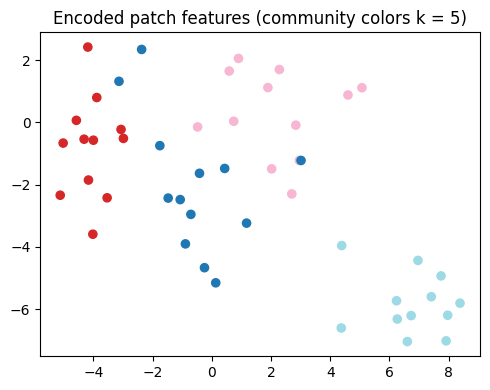

In [31]:
# assume you already have: enc, PATCH, and a single image tensor x: [1,3,224,224]
with torch.no_grad():
    f_after = enc(x, patch=PATCH)[0].cpu().numpy()   # [N,D]
Z_after = tsne_2d(f_after)
Gh = Gw = (x.shape[-1] // PATCH)
rows, cols = grid_labels(Gh, Gw)

"""# A) color by spatial row
scatter_tsne(Z_after, rows, title="t-SNE (color by row)", cmap="viridis")

# B) color by spatial column
scatter_tsne(Z_after, cols, title="t-SNE (color by column)", cmap="plasma")

# C) color by K-Means cluster labels
k = 4
km_labels = KMeans(n_clusters=k, n_init=10, random_state=0).fit_predict(f_after)
scatter_tsne(Z_after, km_labels, title=f"t-SNE (K-Means, k={k})", cmap="tab20")"""

# D) color by graph communities (from kNN on features)
G_feat = knn_graph_from_features(f_after, k=5)
comms = list(nx.algorithms.community.greedy_modularity_communities(G_feat))
comm_label = np.zeros(len(f_after), dtype=int)
for ci, cset in enumerate(comms):
    for v in cset: comm_label[v] = ci
scatter_tsne(Z_after, comm_label, title="Encoded patch features (community colors k = 5)", cmap="tab20")



GPT-analys of plots

* Each dot is one patch embedding (a node in your graph).
You had 49 patches → 49 dots.

* The x and y axes are not real feature dimensions — they’re the two-dimensional t-SNE projection of your high-dimensional embedding space (e.g., 128-D → 2-D).

* Points that are close together in this plot have similar embeddings (cosine or Euclidean) in the original high-dimensional space.
Points that are far apart are dissimilar.

So this gives you a spatialized view of similarity between patches according to the model's learned features.

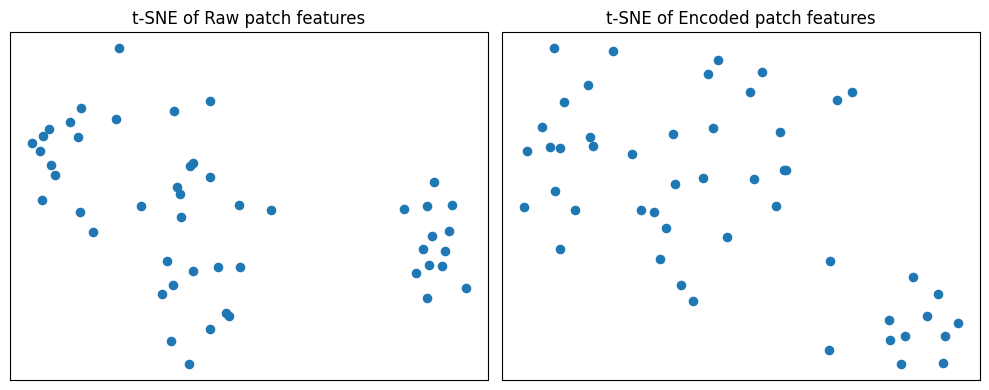

In [32]:
# make an untrained copy (approx “before”)
enc_before = TinyPatchEncoder(dim=128).eval()
with torch.no_grad():
    f_before = enc_before(x, patch=PATCH)[0].cpu().numpy()
    f_after  = enc(x,         patch=PATCH)[0].cpu().numpy()

Z_before = tsne_2d(f_before, seed=0)
Z_after  = tsne_2d(f_after,  seed=0)

# Raw patch graph va encoded feature graph
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.scatter(Z_before[:,0], Z_before[:,1], s=35)
plt.title("t-SNE of Raw patch features"); plt.xticks([]); plt.yticks([])
plt.subplot(1,2,2); plt.scatter(Z_after[:,0], Z_after[:,1], s=35)
plt.title("t-SNE of Encoded patch features");  plt.xticks([]); plt.yticks([])
plt.tight_layout(); plt.show()


t-SNE projection of 49 learned patch embeddings from the Vision GNN encoder. Clusters correspond to visually or semantically similar regions of the image, confirming that the learned graph structure captures coherent patch relationships. Before training, patch embeddings are scattered; after training, clusters emerge and align with spatial or community structure.

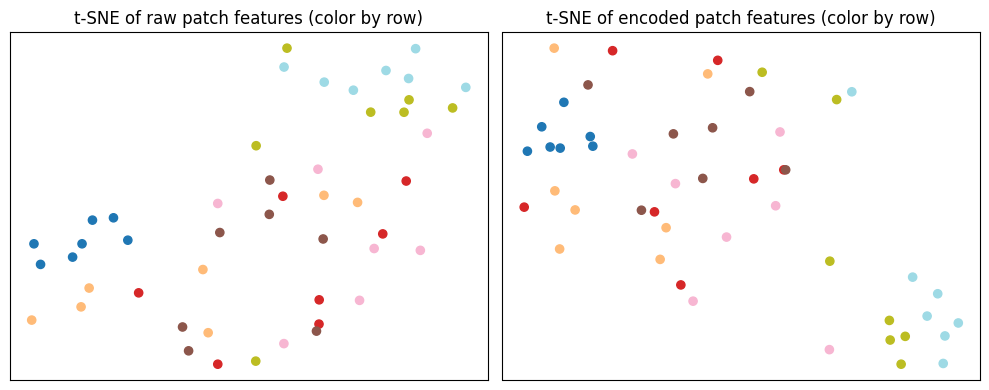

In [29]:
def side_by_side_colored(Z1, Z2, labels, title1, title2, cmap="tab20"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.scatter(Z1[:,0], Z1[:,1], s=35, c=labels, cmap=cmap)
    plt.title(title1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,2,2); plt.scatter(Z2[:,0], Z2[:,1], s=35, c=labels, cmap=cmap)
    plt.title(title2); plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.show()

side_by_side_colored(Z_before, Z_after, rows,
                     "t-SNE of raw patch features (color by row)", "t-SNE of encoded patch features (color by row)")


Before training, patch embeddings are scattered with no clear structure, indicating no learned relationships. After training, distinct clusters emerge, and patches from similar spatial regions group together. This shows that the model learns meaningful visual similarities between patches, forming a structured embedding space for effective graph representation.

# Fixed grid & random graphs

To be continued....